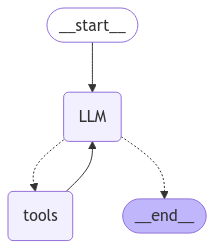

Triggered Tool or Agent: get_news
Here are the latest updates on the Delhi elections:

1. **Economic Times**: Delhi Police have registered a case against the son of Ramesh Bidhuri over a violation of the Model Code of Conduct (MCC), following allegations from Atishi regarding interference during the silence period. AAP members have clashed with police, and the party has developed a website to monitor votes and tally polling data. Arvind Kejriwal has raised concerns about the BJP potentially causing discrepancies in 10% of the votes through machines.
   [Read more](https://economictimes.indiatimes.com/news/newsblogs/delhi-elections-2025-live-updates-date-time-constituencies-parties-manifesto-arvind-kejriwal-atishi-paresh-verma-sandeep-dikshit-aap-bjp-congress-delhi-assembly-elections-eci-latest-news-4-february/liveblog/117899103.cms)

2. **Times of India**: Delhi Chief Minister Atishi accused the BJP of engaging in disruptive activities during the election period.
   [Read more](https:/

In [2]:
# Import the keys
import os
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from openai import AzureOpenAI

load_dotenv()

WEATHER_API_KEY = os.environ['WEATHER_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']

# Retrieve credentials from environment variables
openai_api_version = os.getenv("OPENAI_API_VERSION")
azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")
deployment_name = os.getenv('DEPLOYMENT_NAME_MINI')
groq_api_key = os.getenv('GROQ_API_KEY')

if not os.environ.get("AZURE_OPENAI_API_KEY"):
    os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key

llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=deployment_name,
    openai_api_version=openai_api_version,
)

client = AzureOpenAI(
    azure_endpoint=azure_openai_endpoint,
    api_key=azure_openai_api_key,
    api_version="2024-05-01-preview",
)

# Define the tools
@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

# @tool
# def get_news(query: str) -> list:
#     """Search the news from web"""
#     tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=4, search_depth='advanced', max_tokens=1000)
#     results = tavily_search.invoke(query)
#     return results

@tool
def get_news(query: str) -> str:
    """
    Search the web for news articles related to the query and return the top results with citation links.
    
    Args:
        query (str): The search query for news articles.
    
    Returns:
        str: A formatted string containing the top news results with titles, snippets, and citation links.
    """
    # Initialize TavilySearchResults
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=4, search_depth='advanced', max_tokens=1000)
    
    # Fetch search results
    results = tavily_search.invoke(query)
    
    # Format the results with titles, snippets, and URLs
    formatted_results = []
    for result in results:
        title = result.get("title", "No Title")
        snippet = result.get("content", "No Snippet Available")
        url = result.get("url", "No URL Available")
        
        # Format each result
        formatted_result = f"**Title:** {title}\n**Snippet:** {snippet}\n**Link:** {url}\n"
        formatted_results.append(formatted_result)
    
    # Combine all results into a single string
    return "\n\n".join(formatted_results)

@tool
def translate_text(query: str) -> str:
    """Translates the given query text into the target language."""
    prompt = f'''You are an efficient translator. First, analyze the query and its language, then translate it to the target language.
    ## Given Query: {query}
    Note: In the output, only provide the translation of the query, nothing else.
    ## Desired Output:
    translated text: "your translated text will be here"
    Ensure you follow the output format.
    '''
    messages = [
        {"role": "system", "content": "You are a helpful assistant that translates the given sentence."},
        {"role": "user", "content": prompt},
    ]
    stream = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    return stream.choices[0].message.content

@tool
def analyze_sentiment(query: str) -> str:
    """Performs sentiment analysis on the provided query."""
    prompt = f'''
    You are a sentiment analyzer. First, analyze the sentiment of the given query and detect its language. Then, provide the sentiment analysis result.
    ## Given Query: {query}
    Note: In the output, only provide the sentiment result, nothing else.
    '''
    messages = [
        {"role": "system", "content": "You are a helpful assistant that performs sentiment analysis."},
        {"role": "user", "content": prompt},
    ]
    stream = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    return stream.choices[0].message.content

@tool
def get_financial_data(query: str) -> str:
    """Simulates fetching financial data for a given query."""
    # Simulate financial data retrieval
    return f"Financial data for {query} is not implemented yet."

# List of tools
tools = [get_weather, get_news, translate_text, analyze_sentiment, get_financial_data]
llm_with_tools = llm.bind_tools(tools)

# Intent detection and entity extraction
def detect_intent_and_entities(query: str) -> dict:
    """
    Detects the intent and extracts entities from the user query.
    """
    prompt = f'''
    Analyze the following query and determine the intent and extract relevant entities.
    Query: {query}
    Possible Intents: finance, weather, news, sentiment_analysis, translation
    Entities to Extract: companies, locations, keywords
    Output Format:
    {{
        "intent": "detected_intent",
        "entities": {{
            "companies": ["list", "of", "companies"],
            "locations": ["list", "of", "locations"],
            "keywords": ["list", "of", "keywords"]
        }}
    }}
    '''
    messages = [
        {"role": "system", "content": "You are a helpful assistant that detects intent and extracts entities."},
        {"role": "user", "content": prompt},
    ]
    response = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    return eval(response.choices[0].message.content)

# Tool routing logic
def route_query(query: str) -> str:
    """
    Routes the query to the appropriate tool based on the detected intent.
    If no intent or entities are relevant, the LLM handles the query directly.
    """
    intent_and_entities = detect_intent_and_entities(query)
    intent = intent_and_entities["intent"]
    entities = intent_and_entities["entities"]

    if intent == "finance":
        return get_financial_data(query)
    elif intent == "weather":
        return get_weather(entities["locations"][0])
    elif intent == "news":
        return get_news(entities["keywords"][0])
    elif intent == "sentiment_analysis":
        return analyze_sentiment(query)
    elif intent == "translation":
        return translate_text(query)
    else:
        # If no intent is detected, let the LLM handle the query directly
        messages = [
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": query},
        ]
        response = client.chat.completions.create(
            model=deployment_name,
            messages=messages,
            max_tokens=200,
            temperature=0.2,
        )
        return response.choices[0].message.content

# StateGraph setup
tool_node = ToolNode(tools)

def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    check_tool = last_message.tool_calls
    if check_tool:
        print("Triggered Tool or Agent:", check_tool[0]['name'])
        return "tools"
    return END

# Initialize the workflow
workflow = StateGraph(MessagesState)
workflow.add_node("LLM", call_model)
workflow.add_edge(START, "LLM")
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges("LLM", call_tools)
workflow.add_edge("tools", "LLM")
agent = workflow.compile()



from IPython.display import Image, display

try:
    display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


# Test the agent
query = input("Enter your Query: ")
result = agent.invoke({"messages": [("user", query)]})
result = result["messages"][-1].content
print(result)



In [4]:
# Test the agent
query = input("Enter your Query: ")
result = agent.invoke({"messages": [("user", query)]})
result = result["messages"][-1].content
print(result)

Hello! How can I assist you today?


### memory

#### Bonus Challenge (Optional) - cached memory
For advanced candidates, allow memory to persist across multiple interactions, so a user
does not lose context even if they exit and return later.

Exact Match Checking: The check_history() function looks for identical previous queries

Cached Responses: Immediately returns previous responses for identical queries

Bypass Processing: Skips LLM/tool invocation for repeated queries

How this works:

Checks all previous human messages for exact matches

Returns the immediately following AI response if found

Maintains original behavior for new queries

Works across sessions due to persistent memory

Note: This implements exact string matching. For more sophisticated matching (semantic similarity), you'd need to add vector search capabilities, but this version handles literal repeats efficiently.

In [ ]:
# Import the required modules
import os
import json
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
import requests
from typing import List, Literal
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from openai import AzureOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.schema import HumanMessage, AIMessage

# Load environment variables
load_dotenv()

# Retrieve credentials
WEATHER_API_KEY = os.environ['WEATHER_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']
openai_api_version = os.getenv("OPENAI_API_VERSION")
azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")
deployment_name = os.getenv('DEPLOYMENT_NAME_MINI')

# Configure Azure OpenAI clients
os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key

llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=deployment_name,
    openai_api_version=openai_api_version,
)

client = AzureOpenAI(
    azure_endpoint=azure_openai_endpoint,
    api_key=azure_openai_api_key,
    api_version="2024-05-01-preview",
)

# Initialize persistent memory
memory_file = "conversation_memory.json"
memory = ConversationBufferMemory()

# Load previous conversation history
if os.path.exists(memory_file):
    try:
        with open(memory_file, "r") as f:
            saved_messages = json.load(f)
            for msg_data in saved_messages:
                if msg_data["type"] == "human":
                    memory.chat_memory.add_user_message(msg_data["content"])
                elif msg_data["type"] == "ai":
                    memory.chat_memory.add_ai_message(msg_data["content"])
        print("\nLoaded previous conversation history.")
    except Exception as e:
        print(f"\nError loading memory: {e}")

# Define the tools
@tool
def get_weather(query: str) -> list:
    """Search weatherapi to get the current weather"""
    endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
    response = requests.get(endpoint)
    data = response.json()
    if data.get("location"):
        return data
    else:
        return "Weather Data Not Found"

# @tool
# def get_news(query: str) -> list:
#     """Search the news from web"""
#     tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=4, search_depth='advanced', max_tokens=1000)
#     results = tavily_search.invoke(query)
#     return results

@tool
def get_news(query: str) -> str:
    """
    Search the web for news articles related to the query and return the top results with citation links.
    
    Args:
        query (str): The search query for news articles.
    
    Returns:
        str: A formatted string containing the top news results with titles, snippets, and citation links.
    """
    # Initialize TavilySearchResults
    tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=4, search_depth='advanced', max_tokens=1000)
    
    # Fetch search results
    results = tavily_search.invoke(query)
    
    # Format the results with titles, snippets, and URLs
    formatted_results = []
    for result in results:
        title = result.get("title", "No Title")
        snippet = result.get("content", "No Snippet Available")
        url = result.get("url", "No URL Available")
        
        # Format each result
        formatted_result = f"**Title:** {title}\n**Snippet:** {snippet}\n**Link:** {url}\n"
        formatted_results.append(formatted_result)
    
    # Combine all results into a single string
    return "\n\n".join(formatted_results)

@tool
def translate_text(query: str) -> str:
    """Translates the given query text into the target language."""
    prompt = f'''You are an efficient translator. First, analyze the query and its language, then translate it to the target language.
    ## Given Query: {query}
    Note: In the output, only provide the translation of the query, nothing else.
    ## Desired Output:
    translated text: "your translated text will be here"
    Ensure you follow the output format.
    '''
    messages = [
        {"role": "system", "content": "You are a helpful assistant that translates the given sentence."},
        {"role": "user", "content": prompt},
    ]
    stream = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    return stream.choices[0].message.content

@tool
def analyze_sentiment(query: str) -> str:
    """Performs sentiment analysis on the provided query."""
    prompt = f'''
    You are a sentiment analyzer. First, analyze the sentiment of the given query and detect its language. Then, provide the sentiment analysis result.
    ## Given Query: {query}
    Note: In the output, only provide the sentiment result, nothing else.
    '''
    messages = [
        {"role": "system", "content": "You are a helpful assistant that performs sentiment analysis."},
        {"role": "user", "content": prompt},
    ]
    stream = client.chat.completions.create(
        model=deployment_name,
        messages=messages,
        max_tokens=200,
        temperature=0.2,
    )
    return stream.choices[0].message.content

@tool
def get_financial_data(query: str) -> str:
    """Simulates fetching financial data for a given query."""
    # Simulate financial data retrieval
    return f"Financial data for {query} is not implemented yet."



# Configure LangGraph workflow
tools = [get_weather, get_news, translate_text, analyze_sentiment, get_financial_data]
llm_with_tools = llm.bind_tools(tools)

def detect_intent(query: str) -> dict:
    """Detect intent using Azure OpenAI"""
    response = client.chat.completions.create(
        model=deployment_name,
        messages=[{
            "role": "user",
            "content": f"""Analyze this query and output JSON:
            Query: {query}
            Output format: {{
                "intent": "weather/news/finance/sentiment/translation/general",
                "entities": {{
                    "locations": [],
                    "keywords": [],
                    "companies": []
                }}
            }}"""
        }],
        temperature=0.2
    )
    return eval(response.choices[0].message.content)

def route_query(query: str) -> str:
    """Enhanced routing with memory context"""
    intent_data = detect_intent(query)
    
    if intent_data["intent"] == "weather":
        return get_weather(intent_data["entities"]["locations"][0])
    elif intent_data["intent"] == "news":
        return get_news(" ".join(intent_data["entities"]["keywords"]))
    elif intent_data["intent"] == "finance":
        return get_financial_data(intent_data["entities"]["companies"][0])
    elif intent_data["intent"] == "translation":
        return translate_text(query)
    elif intent_data["intent"] == "sentiment":
        return analyze_sentiment(query)
    else:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[{"role": "user", "content": query}],
            temperature=0.7
        )
        return response.choices[0].message.content

# Configure StateGraph
tool_node = ToolNode(tools)

def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tools(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    check_tool = last_message.tool_calls
    if check_tool:
        print("\n\n")
        print("Triggered Tool or Agent:", check_tool[0]['name'])
        return "tools"
    return END


workflow = StateGraph(MessagesState)
workflow.add_node("LLM", call_model)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "LLM")
workflow.add_conditional_edges("LLM", call_tools)
workflow.add_edge("tools", "LLM")
agent = workflow.compile()


def check_history(query: str) -> str | None:
    """Check for exact query matches in history"""
    history = memory.load_memory_variables({})['history']
    messages = memory.chat_memory.messages
    
    for i in range(0, len(messages), 2):
        if i+1 >= len(messages):
            break
        if isinstance(messages[i], HumanMessage) and messages[i].content == query:
            return messages[i+1].content  # Return next message (AI response)
    return None



# Main interaction loop with persistent memory
try:
    while True:
        query = input("\nYou: ")
        if query.lower() in ['exit', 'quit']:
            break
        
        # Check for existing response in history
        cached_response = check_history(query)
        if cached_response:
            print(f"\nAssistant (cached): {cached_response}")
            continue
            
        # Rest of original processing flow
        memory.chat_memory.add_user_message(query)
        messages = []
        for msg in memory.chat_memory.messages:
            role = "user" if isinstance(msg, HumanMessage) else "assistant"
            messages.append((role, msg.content))
        
        response = agent.invoke({"messages": messages})
        ai_response = response["messages"][-1].content
        
        memory.chat_memory.add_ai_message(ai_response)
        print(f"\nAssistant: {ai_response}")

finally:
    # Save conversation history
    try:
        with open(memory_file, "w") as f:
            history = [{
                "type": "human" if isinstance(msg, HumanMessage) else "ai",
                "content": msg.content
            } for msg in memory.chat_memory.messages]
            json.dump(history, f, indent=2)
        print("\nConversation history saved successfully.")
    except Exception as e:
        print(f"\nError saving memory: {e}")


Loaded previous conversation history.


Triggered Tool or Agent: translate_text

Assistant: The phrase "I am happy" translates to French as **"Je suis heureux"** (for a male speaker) or **"Je suis heureuse"** (for a female speaker).

Regarding sentiment, the analysis indicates that the sentiment around the phrase "I am happy" is **positive**.

Assistant (cached): It seems that your message was empty. How can I assist you further?

Conversation history saved successfully.


## Deepseek = evaluation answers

1. **Routing Logic & Intent Detection**:

- The code uses `detect_intent` which sends a prompt to Azure OpenAI to classify the query into an intent and extract entities. But how accurate is this? Maybe there's no validation if entities exist before using them. For example, if "locations" is empty but the intent is "weather", it would crash when accessing `intent_data["entities"]["locations"][0]`.

2. **Agent Framework Implementation**:

- LangGraph's StateGraph is set up with nodes and edges. The agent uses a workflow with LLM and tools. But does it handle tool execution properly? The `call_tools` function checks for tool calls and routes accordingly. But maybe there's no error handling if a tool fails.

3. **Memory Usage**:

- ConversationBufferMemory is used with persistent storage in a JSON file. It loads previous conversations and saves on exit. The `check_history` function looks for exact matches. However, this might not handle similar but not identical queries. Also, does the memory integrate with the agent's state correctly?

4. **Code Quality**:

- The code is structured with functions and tools, but some parts could be more modular. For example, the `route_query` function directly calls tools without error handling. Also, the `detect_intent` uses `eval` on the response, which is a security risk if the model's output isn't controlled.

5. **Handling Edge Cases**:

- Tools like `get_weather` check if the data has a "location" key, but others like `get_news` don't handle empty results. If Tavily returns no results, it might still try to format them, causing errors. Also, intent detection might misclassify, leading to incorrect tool calls without fallbacks.

6. **Bonus (Multi-step Queries)**:

- The current code routes to a single tool per query. For a query like "Stock price of Apple and sentiment around it", the agent would need to call `get_financial_data` and `analyze_sentiment` sequentially. The existing setup doesn't support chaining tools or handling multi-intent queries.

**Improvement Steps**:

- **Routing & Intent**: Add validation for entities, handle empty cases, and improve the intent detection prompt for accuracy. Maybe use a schema with Pydantic for safer parsing.

- **Agent Framework**: Implement error handling for tool executions, add retries or fallback responses.

- **Memory**: Enhance `check_history` to consider semantic similarity, not just exact matches. Use memory within the agent's state to maintain context for multi-step queries.

- **Code Quality**: Refactor into classes or separate modules for better organization. Replace `eval` with JSON parsing and validation.

- **Edge Cases**: Add try/except blocks around tool calls, provide user-friendly error messages, handle empty results from APIs.

- **Multi-step Queries**: Modify the agent workflow to allow chaining tools. For example, after getting financial data, automatically analyze sentiment if needed. Use the LLM to decide if multiple tools are required and orchestrate their execution.

**Testing Plan**:

- Unit tests for each tool, checking responses and error cases.

- Integration tests for the agent workflow with different query types.

- Test multi-step queries to ensure tools are called in sequence.

- Validate memory persistence across sessions and correct retrieval of cached responses.

**Potential Risks**:

- Security issues with `eval` in `detect_intent`.

- Tools failing and crashing the agent without feedback.

- Memory growing too large without pruning, leading to performance issues.

- Incorrect routing leading to irrelevant tool calls or responses.

**Final Steps**:

Implement the identified improvements step by step, test each part, and ensure the evaluation criteria are met. Focus on robustness, accuracy, and user experience.

## GPT - evaluation answer

Evaluating your AI agent involves assessing various aspects to ensure it functions effectively and efficiently. Here's a structured evaluation based on the provided criteria:

1. Routing Logic & Intent Detection

Assessment: The detect_intent function utilizes Azure OpenAI to classify user queries into predefined intents such as "weather," "news," "finance," "sentiment," "translation," or "general." This classification directs the query to the appropriate function for processing.

Evaluation:

Accuracy: Ensure that the intent detection accurately classifies a diverse set of user inputs. Consider testing with various phrasings and edge cases to validate robustness.

Scalability: If new intents are added in the future, assess how easily the system can accommodate them. The current structure should allow for straightforward expansion.

2. Agent Framework Implementation

Assessment: The code employs the LangGraph framework to manage the workflow between the language model and the tools. The StateGraph is configured to handle the flow of messages and tool invocations.

Evaluation:

Modularity: The separation of concerns is well-maintained, with distinct functions for each tool and clear workflow management.

Integration: The binding of tools to the language model (llm_with_tools) is effectively implemented, allowing seamless tool invocation during interactions.

3. Memory Usage

Assessment: The ConversationBufferMemory is used to maintain a history of interactions, which is loaded from and saved to a JSON file (conversation_memory.json). This enables context retention across sessions.

Evaluation:

Persistence: The mechanism for loading and saving conversation history ensures that the agent can recall previous interactions, enhancing user experience.

Efficiency: Consider the potential growth of the memory file over time. Implementing strategies for memory management, such as summarizing older interactions, could be beneficial.

4. Code Quality

Assessment: The code is structured with clear function definitions, appropriate use of comments, and logical flow.

Evaluation:

Readability: The use of descriptive function names and comments aids in understanding the code's purpose and functionality.

Maintainability: The modular design allows for easy updates and debugging. However, ensure that exception handling is consistently implemented across all functions to enhance robustness.

5. Handling Edge Cases

Assessment: The code includes basic error handling, such as checking for the existence of location data in the get_weather function.

Evaluation:

Graceful Degradation: In scenarios where data is unavailable or an error occurs, the system should provide informative messages to the user. Expanding error handling to cover all functions will improve resilience.

Unexpected Inputs: Test the system with a variety of unexpected inputs to ensure it responds appropriately without crashing or producing erroneous outputs.

6. Bonus: Handling Multi-Step Queries

Assessment: The current implementation routes queries to specific functions based on detected intent but does not inherently support multi-step query handling.

Evaluation:

Sequential Tool Invocation: To handle queries like "Stock price of Apple and sentiment around it," the system would need to invoke multiple tools in sequence. Implementing a mechanism to parse such queries and manage sequential tool calls would enhance functionality.
Recommendations:

Enhance Intent Detection: Consider incorporating more advanced natural language understanding techniques or training a custom model to improve intent detection accuracy.

Expand Error Handling: Implement comprehensive exception handling across all functions to manage potential failures gracefully.

Implement Multi-Step Query Handling: Develop a strategy to parse and execute multi-step queries, possibly by decomposing them into individual intents and processing them sequentially.

Optimize Memory Management: As the conversation history grows, consider methods to manage memory usage, such as summarizing older interactions or setting retention limits.

By addressing these areas, the AI agent will become more robust, user-friendly, and capable of handling a wider range of user interactions effectively.




In [11]:
# Import the required modules
import os
import json
import time
import numpy as np
from dotenv import load_dotenv
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END
import requests
from typing import List, Literal, Tuple, Dict, Any
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_openai import AzureChatOpenAI
from openai import AzureOpenAI
from langchain.memory import ConversationBufferWindowMemory
from langchain.schema import HumanMessage, AIMessage
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pydantic import BaseModel

# Load environment variables
load_dotenv()

# Retrieve credentials
WEATHER_API_KEY = os.environ['WEATHER_API_KEY']
TAVILY_API_KEY = os.environ['TAVILY_API_KEY']
openai_api_version = os.getenv("OPENAI_API_VERSION")
azure_openai_endpoint = os.getenv("ENDPOINT_URL_MINI")
azure_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY_MINI")
deployment_name = os.getenv('DEPLOYMENT_NAME_MINI')

# Configure Azure OpenAI clients
os.environ["AZURE_OPENAI_API_KEY"] = azure_openai_api_key

llm = AzureChatOpenAI(
    azure_endpoint=azure_openai_endpoint,
    azure_deployment=deployment_name,
    openai_api_version=openai_api_version,
)

client = AzureOpenAI(
    azure_endpoint=azure_openai_endpoint,
    api_key=azure_openai_api_key,
    api_version="2024-05-01-preview",
)

# Initialize persistent memory and encoder for semantic caching
memory_file = "conversation_memory.json"
encoder = SentenceTransformer('all-MiniLM-L6-v2')
memory = ConversationBufferWindowMemory(k=6, return_messages=True)

# Load previous conversation history
if os.path.exists(memory_file):
    try:
        with open(memory_file, "r") as f:
            saved_messages = json.load(f)
            for msg_data in saved_messages:
                if msg_data["type"] == "human":
                    memory.chat_memory.add_user_message(msg_data["content"])
                elif msg_data["type"] == "ai":
                    memory.chat_memory.add_ai_message(msg_data["content"])
        print("\nLoaded previous conversation history.")
    except Exception as e:
        print(f"\nError loading memory: {e}")

# Define tools with error handling
@tool
def get_weather(query: str) -> str:
    """Get current weather using weatherapi"""
    try:
        endpoint = f"http://api.weatherapi.com/v1/current.json?key={WEATHER_API_KEY}&q={query}"
        response = requests.get(endpoint, timeout=10)
        response.raise_for_status()
        data = response.json()
        return f"{data['location']['name']}: {data['current']['temp_c']}°C"
    except Exception as e:
        return f"⚠️ Weather service error: {str(e)}"

@tool
def get_news(query: str) -> str:
    """Get news articles with Tavily"""
    try:
        tavily_search = TavilySearchResults(api_key=TAVILY_API_KEY, max_results=4)
        results = tavily_search.invoke(query)
        return "\n\n".join(
            f"**{res['title']}**\n{res['content']}\nLink: {res['url']}"
            for res in results
        )
    except Exception as e:
        return f"⚠️ News service error: {str(e)}"

@tool
def translate_text(query: str) -> str:
    """Translate text using Azure OpenAI"""
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[{
                "role": "user",
                "content": f"Translate this to English: {query}. Respond only with the translation."
            }],
            temperature=0.2
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"⚠️ Translation error: {str(e)}"

@tool
def analyze_sentiment(query: str) -> str:
    """Analyze sentiment using Azure OpenAI"""
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            messages=[{
                "role": "user", 
                "content": f"Analyze sentiment: {query}. Respond with ONLY the sentiment label (positive/negative/neutral)."
            }],
            temperature=0.2
        )
        return response.choices[0].message.content
    except Exception as e:
        return f"⚠️ Sentiment analysis error: {str(e)}"

@tool
def get_financial_data(query: str) -> str:
    """Fetch financial data"""
    try:
        # Simulated financial data
        return f"📈 {query} (Simulated)\nOpen: $150\nHigh: $155\nLow: $148"
    except Exception as e:
        return f"⚠️ Financial service error: {str(e)}"

# Intent detection model
class IntentData(BaseModel):
    intents: List[str]
    entities: Dict[str, List[str]]

def detect_intent(query: str) -> IntentData:
    """Detect multiple intents from query"""
    try:
        response = client.chat.completions.create(
            model=deployment_name,
            response_format={"type": "json_object"},
            messages=[{
                "role": "system",
                "content": """Analyze query and output JSON with:
                - intents: list of detected intents (weather/news/finance/sentiment/translation)
                - entities: {locations, keywords, companies}"""
            }, {
                "role": "user",
                "content": query
            }]
        )
        return IntentData.parse_raw(response.choices[0].message.content)
    except Exception as e:
        print(f"⚠️ Intent detection error: {e}")
        return IntentData(intents=["general"], entities={})

# Evaluation metrics tracker
class EvaluationMetrics:
    def __init__(self):
        self.total_queries = 0
        self.successful_responses = 0
        self.response_times = []
        self.tool_usage = {tool.name: 0 for tool in tools}
        self.error_count = 0

    def track_query(self, success: bool, response_time: float):
        self.total_queries += 1
        if success:
            self.successful_responses += 1
        self.response_times.append(response_time)

    def track_tool_usage(self, tool_name: str):
        if tool_name in self.tool_usage:
            self.tool_usage[tool_name] += 1

    def track_error(self):
        self.error_count += 1

    def generate_report(self) -> Dict[str, Any]:
        return {
            "success_rate": self.successful_responses / self.total_queries if self.total_queries else 0,
            "avg_response_time": np.mean(self.response_times) if self.response_times else 0,
            "tool_usage": self.tool_usage,
            "error_rate": self.error_count / self.total_queries if self.total_queries else 0
        }

# Configure LangGraph workflow
tools = [get_weather, get_news, translate_text, analyze_sentiment, get_financial_data]
llm_with_tools = llm.bind_tools(tools)
metrics = EvaluationMetrics()

class FinancialAgent:
    def __init__(self):
        self.workflow = self._build_workflow()
        self.metrics = EvaluationMetrics()

    def _build_workflow(self):
        workflow = StateGraph(MessagesState)
        
        workflow.add_node("LLM", self.call_model)
        workflow.add_node("tools", self.handle_tools)
        workflow.add_node("multi_step", self.handle_multi_step)
        
        workflow.add_edge(START, "LLM")
        workflow.add_conditional_edges(
            "LLM",
            self.route_processing
        )
        workflow.add_conditional_edges(
            "tools",
            lambda state: END if "error" in state else "LLM"
        )
        workflow.add_edge("multi_step", "LLM")
        
        return workflow.compile()

    def call_model(self, state: MessagesState):
        messages = state["messages"]
        response = llm_with_tools.invoke(messages)
        return {"messages": [response]}

    def handle_tools(self, state: MessagesState):
        try:
            return ToolNode(tools)(state)
        except Exception as e:
            return {"messages": [AIMessage(content=f"⚠️ Tool error: {str(e)}")]}

    def handle_multi_step(self, state: MessagesState):
        messages = state["messages"]
        query = messages[-1].content
        intents = detect_intent(query)
        
        results = []
        for intent in intents.intents:
            result = self.route_single_intent(intent, intents.entities)
            results.append(result)
            self.metrics.track_tool_usage(intent)
        
        return {"messages": [AIMessage(content="\n\n".join(results))]}

    def route_processing(self, state: MessagesState):
        messages = state["messages"]
        query = messages[-1].content if messages else ""
        
        if " and " in query.lower() or " also " in query.lower():
            return "multi_step"
        if messages[-1].tool_calls:
            return "tools"
        return END

    def route_single_intent(self, intent: str, entities: dict) -> str:
        try:
            if intent == "weather":
                return get_weather(entities.get("locations", ["Unknown"])[0])
            elif intent == "news":
                return get_news(" ".join(entities.get("keywords", [])))
            elif intent == "finance":
                return get_financial_data(entities.get("companies", ["Unknown"])[0])
            elif intent == "translation":
                return translate_text(" ".join(entities.get("keywords", [])))
            elif intent == "sentiment":
                return analyze_sentiment(" ".join(entities.get("keywords", [])))
            return "⚠️ Could not process request"
        except Exception as e:
            return f"⚠️ Processing error: {str(e)}"

# Semantic caching
def check_history(query: str, threshold: float = 0.85) -> str:
    query_embed = encoder.encode(query)
    for i, msg in enumerate(memory.chat_memory.messages):
        if isinstance(msg, HumanMessage):
            msg_embed = encoder.encode(msg.content)
            similarity = cosine_similarity([query_embed], [msg_embed])[0][0]
            if similarity > threshold and (i+1) < len(memory.chat_memory.messages):
                return memory.chat_memory.messages[i+1].content
    return None

# Main execution
if __name__ == "__main__":
    agent = FinancialAgent()
    metrics = EvaluationMetrics()
    
    try:
        while True:
            start_time = time.time()
            query = input("\nYou: ").strip()
            
            if query.lower() in ['exit', 'quit']:
                break
                
            if not query:
                continue

            # Check cached responses
            cached = check_history(query)
            if cached:
                print(f"\nAssistant (cached): {cached}")
                metrics.track_query(True, time.time()-start_time)
                continue

            # Process new query
            memory.chat_memory.add_user_message(query)
            
            try:
                response = agent.workflow.invoke({
                    "messages": [
                        (msg.type, msg.content) 
                        for msg in memory.chat_memory.messages
                    ]
                })
                ai_response = response["messages"][-1].content
                success = "⚠️" not in ai_response
                
                # Track tool usage
                for tool in tools:
                    if tool.name in ai_response:
                        metrics.track_tool_usage(tool.name)
                
            except Exception as e:
                ai_response = f"⚠️ System error: {str(e)}"
                success = False
                metrics.track_error()

            # Update metrics and memory
            metrics.track_query(success, time.time()-start_time)
            memory.chat_memory.add_ai_message(ai_response)
            print(f"\nAssistant: {ai_response}")

    finally:
        # Save conversation history
        try:
            with open(memory_file, "w") as f:
                history = [{
                    "type": "human" if isinstance(msg, HumanMessage) else "ai",
                    "content": msg.content
                } for msg in memory.chat_memory.messages]
                json.dump(history, f, indent=2)
            
            # Generate final report
            report = metrics.generate_report()
            print("\n=== Evaluation Report ===")
            print(f"Success Rate: {report['success_rate']:.1%}")
            print(f"Avg Response Time: {report['avg_response_time']:.2f}s")
            print("Tool Usage:")
            for tool, count in report['tool_usage'].items():
                print(f"  - {tool}: {count}")
            print(f"Error Rate: {report['error_rate']:.1%}")
            
        except Exception as e:
            print(f"⚠️ Failed to save data: {str(e)}")


Loaded previous conversation history.

Assistant: 2 + 2 equals 4.

Assistant: ⚠️ System error: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_NezKxHXNM1tYm8pLG9kzpgN9", 'type': 'invalid_request_error', 'param': 'messages.[22].role', 'code': None}}

=== Evaluation Report ===
Success Rate: 50.0%
Avg Response Time: 16.14s
Tool Usage:
  - get_weather: 0
  - get_news: 0
  - translate_text: 0
  - analyze_sentiment: 0
  - get_financial_data: 0
Error Rate: 50.0%


## GROQ

In [3]:
# from langchain_groq import ChatGroq
# from langchain_core.prompts import ChatPromptTemplate

# # Initialize the ChatGroq model
# llm = ChatGroq(
#     model="llama-3.3-70b-versatile",
#     temperature=0.5,
#     api_key=groq_api_key
# )
# llm
